### Test on 2017

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import ARIMA
from darts.models import AutoARIMA
from darts.metrics import mape, mae, rmse

sp500 = yf.Ticker("^GSPC")
df = sp500.history(start="2010-01-01", end="2017-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2016) and test (2017)
train_ts, test_ts = series.split_before(pd.Timestamp("2017-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_40488\1279762260.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


##### Seasonal length is the pattern of the season

depends on the frequency define above, 52 for a year if freq is weekly, 252 for a year if freq is daily, 12 for a year if freq is monthly

In [8]:
# instantiate an AutoARIMA model that will search both non‐seasonal and seasonal terms
auto_sarima = AutoARIMA(
    # Base parameter
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=2, max_q=5,

    # Seasonal parameter
    start_P=1, D=1, start_Q=1,
    max_P=2, max_D=1, max_Q=2,
    
    season_length=52, # 52 weeks per year, pattern for one year
    stepwise=True, # walks towards good model, instead of checking every possible combination
    random_state=42,
)

# fit on training data
auto_sarima.fit(train_ts)

AutoARIMA(add_encoders=None, quantiles=None, random_state=42, start_p=1, d=1, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=1, start_Q=1, max_P=2, max_D=1, max_Q=2, season_length=52, stepwise=True)

In [9]:
# forecast the same number of steps as in the test set
h = len(test_ts)
arima_forecast = auto_sarima.predict(n=h)

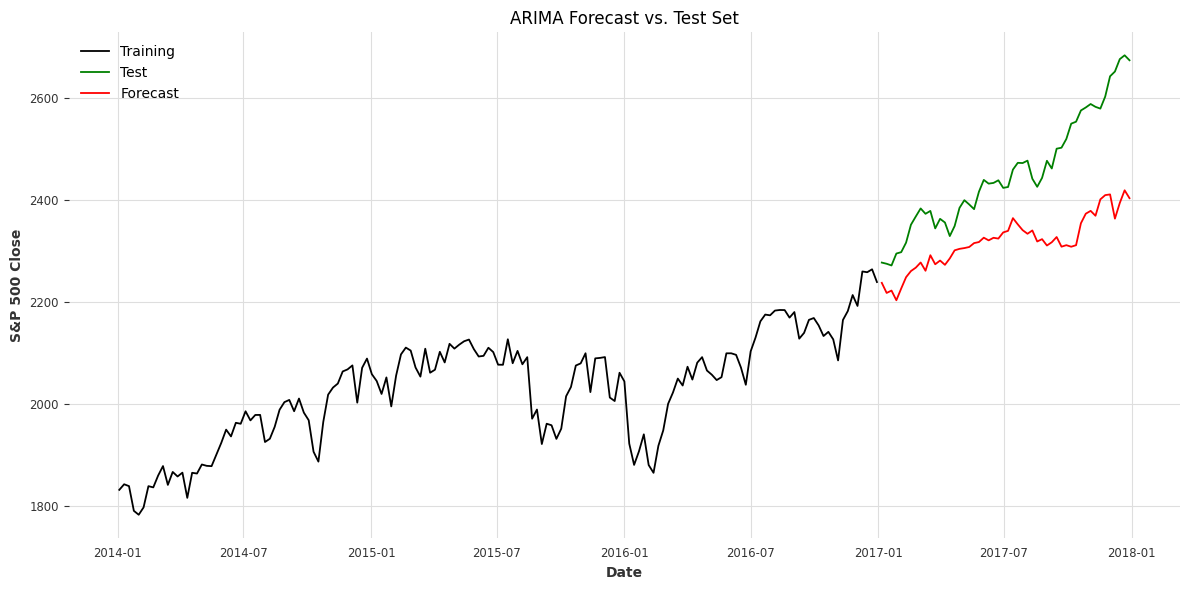

In [10]:
# get only the part of train_ts from 2014-01-01 onward
train_slice = train_ts.slice(pd.Timestamp("2014-01-01"), train_ts.end_time())

# plot train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_slice.time_index, train_slice.values(), label="Training")
plt.plot(test_ts.time_index, test_ts.values(), label="Test", color="green")
plt.plot(arima_forecast.time_index, arima_forecast.values(), label="Forecast", color="red")

plt.title("ARIMA Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# evaluate
print("ARIMA Results")
print("----------------")
print(f"MAPE: {mape(test_ts, arima_forecast):.2f}%")
print(f"MAE:  {mae(test_ts, arima_forecast):.2f}")
print(f"RMSE: {rmse(test_ts, arima_forecast):.2f}\n")

ARIMA Results
----------------
MAPE: 5.38%
MAE:  134.44
RMSE: 150.83



### Test on 2023 and 2024

In [84]:
# load data
df = sp500.history(start="2014-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)

# Fix missing data
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

# split into train (up to 2012-2022) and test (2023-2024)
train_ts_2, test_ts_2 = series.split_before(pd.Timestamp("2023-01-01"))

C:\Users\USER\AppData\Local\Temp\ipykernel_40488\3240597983.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [92]:
# instantiate an AutoARIMA model that will search both non‐seasonal and seasonal terms
auto_sarima_2 = AutoARIMA(
    # Base parameter
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=2, max_q=5,

    # Seasonal parameter
    start_P=1, D=1, start_Q=1,
    max_P=2, max_D=1, max_Q=2,
    
    season_length=52, # 52 weeks / 1 year pattern for seasonal
    stepwise=True, # walks towards good model, instead of checking every possible combination
    random_state=42,
)

# fit on training data
auto_sarima_2.fit(train_ts_2)

AutoARIMA(add_encoders=None, quantiles=None, random_state=42, start_p=1, d=1, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=1, start_Q=1, max_P=2, max_D=1, max_Q=2, season_length=52, stepwise=True)

In [89]:
# forecast the same number of steps as in the test set
h = len(test_ts_2)
arima_forecast_2 = auto_sarima_2.predict(n=h) # recursive

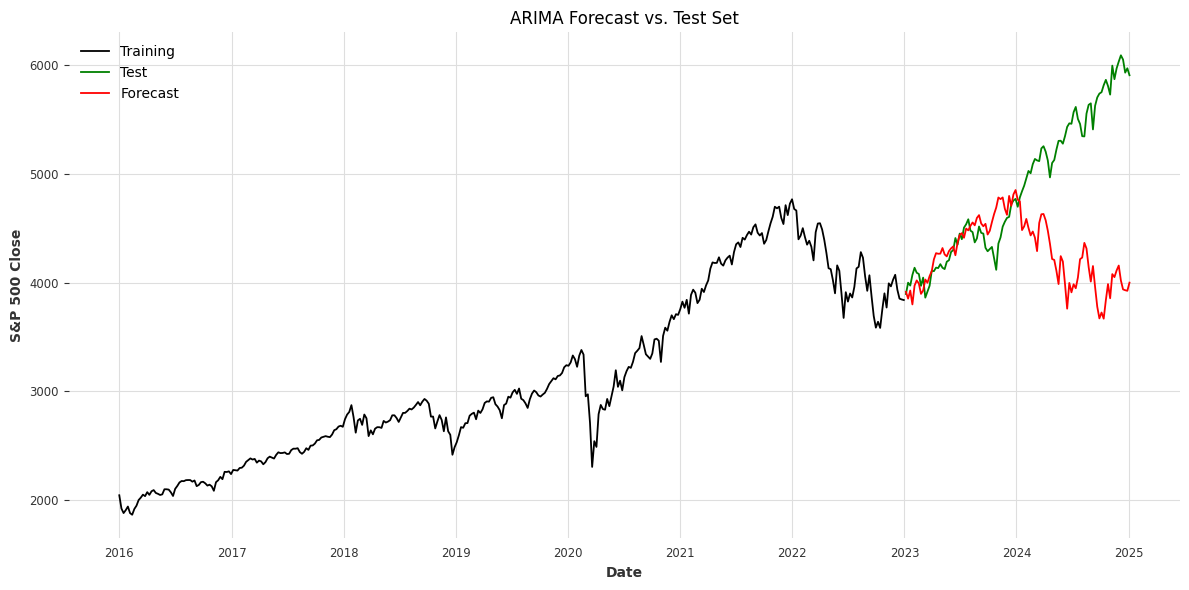

In [90]:
# get only the part of train_ts from 2016-01-01 onward
train_slice_2 = train_ts_2.slice(pd.Timestamp("2016-01-01"), train_ts_2.end_time())

# plot train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_slice_2.time_index, train_slice_2.values(), label="Training")
plt.plot(test_ts_2.time_index, test_ts_2.values(), label="Test", color="green")
plt.plot(arima_forecast_2.time_index, arima_forecast_2.values(), label="Forecast", color="red")

plt.title("ARIMA Forecast vs. Test Set")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
# evaluate
print("ARIMA Results")
print("----------------")
print(f"MAPE: {mape(test_ts_2, arima_forecast_2):.2f}%")
print(f"MAE:  {mae(test_ts_2, arima_forecast_2):.2f}")
print(f"RMSE: {rmse(test_ts_2, arima_forecast_2):.2f}\n")

ARIMA Results
----------------
MAPE: 13.01%
MAE:  707.25
RMSE: 1008.00



### Backtesting

In [93]:
df = sp500.history(start="2016-01-01", end="2024-12-31")[["Close"]].dropna()
df.index = pd.to_datetime(df.index).tz_localize(None)
all_bd = pd.date_range(df.index.min(), df.index.max(), freq="B")
df = df.reindex(all_bd)
df["Close"].ffill(inplace=True)

# resample to weekly
weekly = df["Close"].resample("W-FRI").last().to_frame()

# convert to a darts TimeSeries
series = TimeSeries.from_series(
    weekly["Close"],
    fill_missing_dates=True,
    freq="W"
)

C:\Users\USER\AppData\Local\Temp\ipykernel_40488\400281087.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Close"].ffill(inplace=True)


In [94]:
# back test period
backtest_start = pd.Timestamp("2024-01-01")
backtest_end   = pd.Timestamp("2024-12-31")

In [95]:
# instantiate an AutoARIMA model that will search both non‐seasonal and seasonal terms
auto_sarima_3 = AutoARIMA(
    # Base parameter
    start_p=1, d=1, start_q=1,
    max_p=5, max_d=2, max_q=5,

    # Seasonal parameter
    start_P=1, D=1, start_Q=1,
    max_P=2, max_D=1, max_Q=2,
    
    season_length=52, # 52 here as backtesting will be on weekly base
    stepwise=True,
    random_state=42,
)

# fit on training data
auto_sarima_3.fit(series[:backtest_start]) # use series as a whole

AutoARIMA(add_encoders=None, quantiles=None, random_state=42, start_p=1, d=1, start_q=1, max_p=5, max_d=2, max_q=5, start_P=1, D=1, start_Q=1, max_P=2, max_D=1, max_Q=2, season_length=52, stepwise=True)

In [98]:
# perform the historical (rolling) forecasts
backtest_forecast = auto_sarima_3.historical_forecasts(
    series=series,
    start=backtest_start,
    forecast_horizon=1,    # 1 week ahead
    stride=1,              # roll forward 1 week each time
    retrain=True,         # No re-fit on all data up to each forecast point
    last_points_only=True  # keep only the 1-step-ahead point per window
)

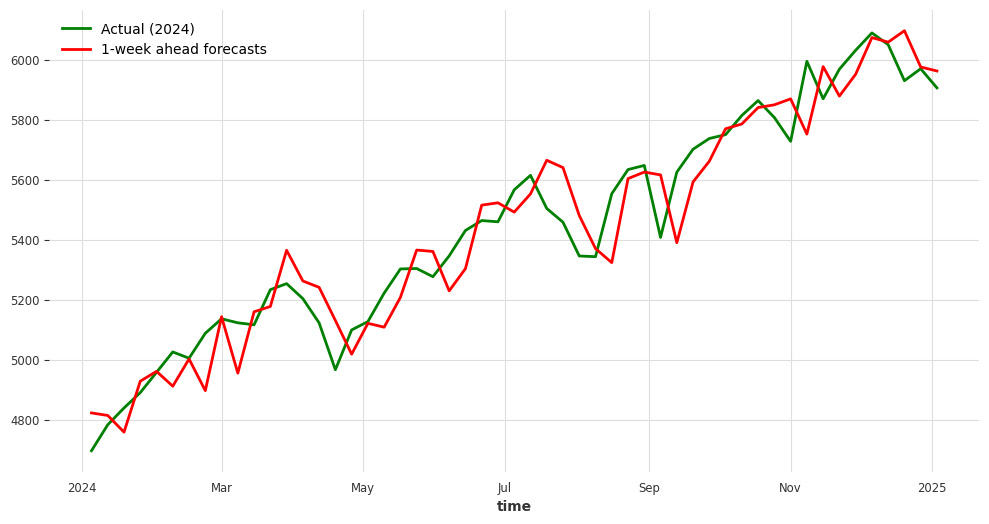

MAPE: 1.63%
MAE:  88.54
RMSE: 109.71


In [100]:
# slice actuals to the same indices
actuals_bt = series[backtest_start:backtest_end]

# plot
plt.figure(figsize=(12,6))
actuals_bt.plot(label="Actual (2024)", color="green")
backtest_forecast.plot(label="1-week ahead forecasts", color="red")
plt.legend()
plt.show()

# evaluate
print(f"MAPE: {mape(actuals_bt, backtest_forecast):.2f}%")
print(f"MAE:  {mae(actuals_bt, backtest_forecast):.2f}")
print(f"RMSE: {rmse(actuals_bt, backtest_forecast):.2f}")